# TO-DO LIST

- Improve dataset
    - MAYBE: Remove rows in which any given fighter has less than 3 UFC fights under their belt
    - ~~Better method for getting fighter record~~
    - ~~Handle duplicate names instead of remove~~
    - Add in missing stats like...
        - ~~days since last fight~~
        - ~~stance~~
        - ~~weightclass~~
        - ~~record~~
        - ~~tott~~
        - ~~differentials~~
        - time format
        - interaction terms between relevant features
    - Research best strategy to impute Nan's 
    - Normalize stats
    - Check for covariate drift
    - Remove bad features
        - check distribution of all stat correlations with outcome?
    - Remove WMMA?
        - Try only WMMA?
    - See if it works when we pull data again
        - Once it does, we need to build this into a real pipeline outside of jupyter
- Get odds data
- Build models with profit objective
    - Try many different types of models
    - Optimize for calibration
- Squeeze out profitability
    - Manufacture new statistics
        - ELO
        - Sentiment
        - Fighter type
        - Ask ChatGPT for suggestions
    - Research techniques for better calibration
    - Try predicting more specific bet types
        - Fight goes to decision?
        - Type of finish

# Load and Clean the Data

There are four datasets we will need:

* Fights (specific fight details and the bulk of the statistics)
* Fight Results (who won, method, time, details)
* Fighters (tott)
* Events (this provides event data for finding a fighter's last time in the ring)

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb

fight_details_df = pd.read_csv('scrape_ufc_stats/ufc_fight_details.csv').dropna()
fights_df = pd.read_csv('scrape_ufc_stats/ufc_fight_stats.csv').dropna()
fight_results_df = pd.read_csv('scrape_ufc_stats/ufc_fight_results.csv').dropna()
fighters_df = pd.read_csv('scrape_ufc_stats/ufc_fighter_tott.csv').dropna()
events_df = pd.read_csv('scrape_ufc_stats/ufc_event_details.csv').dropna()

### Clean Fight Details DataFrame

In [2]:
""" Rename columns """
def standardize_col (col_name: str) -> str:
    out = col_name.lower()
    out = out.replace('.', ' ')
    out = out.replace('%', 'pct')
    out = out.strip().replace(' ', '_')
    out = out.replace('__', '_')
    return out

fight_details_df.rename(columns={i: standardize_col(i) for i in fight_details_df.columns}, inplace=True)


### Clean Fights DataFrame

In [3]:


fights_df.rename(columns={i: standardize_col(i) for i in fights_df.columns}, inplace=True)

""" Clean columns """

# Remove 'Round' from round col
fights_df['round'] = fights_df['round'].map(lambda x: int(x.split(' ')[1])) # 'Round 1' -> 1

# Separate out columns with 'x of y' in them into two cols (e.g. 'head' and 'head_att' for head attempts)
def separate_ratio_col (df: pd.DataFrame, col_name: str) -> pd.Series:
    df[f'{col_name}_att'] = df[col_name].map(lambda x: int(x.split(' of ')[1]))
    df[col_name] = df[col_name].map(lambda x: int(x.split(' of ')[0]))

separate_ratio_col(fights_df, 'sig_str')
separate_ratio_col(fights_df, 'total_str')
separate_ratio_col(fights_df, 'td')
separate_ratio_col(fights_df, 'head')
separate_ratio_col(fights_df, 'body')
separate_ratio_col(fights_df, 'leg')
separate_ratio_col(fights_df, 'distance')
separate_ratio_col(fights_df, 'clinch')
separate_ratio_col(fights_df, 'ground')

# Remove percent signs
def remove_percent (x):
    if x != '---':
        return float(x.replace('%', ''))
    else:
        return np.nan
fights_df.sig_str_pct = fights_df.sig_str_pct.map(remove_percent)
fights_df.td_pct = fights_df.td_pct.map(remove_percent)

def time_to_sec (x):
    if x != '--':
        parts = x.split(':')
        return int(parts[0]) * 60 + int(parts[1])
    return np.nan
    
fights_df.ctrl = fights_df.ctrl.map(time_to_sec)

def get_opponent_name (x):
    fighters = np.unique(x)
    temp = []
    for fighter in x:
        if fighter == fighters[0]:
            temp.append(fighters[1])
        else:
            temp.append(fighters[0])
    return temp

""" Aggregate Round Data """
opponent_mapping = fights_df.groupby(['event', 'bout', 'round'])['fighter'].transform(get_opponent_name)
fights_df['opponent_name'] = opponent_mapping

fights_df = fights_df.merge(fights_df, left_on=['event', 'bout', 'round', 'opponent_name'], right_on=['event', 'bout', 'round', 'fighter'], suffixes=('', '_allowed'))

fights_df.drop(columns=['fighter_allowed', 'sig_str_pct', 'td_pct', 'sig_str_pct_allowed', 'td_pct_allowed', 'opponent_name_allowed'], inplace=True)

fights_df.head()

,event,bout,round,fighter,kd,sig_str,total_str,td,sub_att,rev,...,ground_allowed,sig_str_att_allowed,total_str_att_allowed,td_att_allowed,head_att_allowed,body_att_allowed,leg_att_allowed,distance_att_allowed,clinch_att_allowed,ground_att_allowed
0,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,1,Ciryl Gane,0.0,51,52,0,0.0,0.0,...,0,26,26,1,23,1,2,26,0,0
1,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,2,Ciryl Gane,0.0,58,58,0,0.0,0.0,...,0,18,18,0,15,2,1,18,0,0
2,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,1,Serghei Spivac,0.0,7,7,0,0.0,0.0,...,0,69,70,0,32,24,13,68,1,0
3,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,2,Serghei Spivac,0.0,4,4,0,0.0,0.0,...,0,87,87,0,53,25,9,84,3,0
4,UFC Fight Night: Gane vs. Spivac,Manon Fiorot vs. Rose Namajunas,1,Manon Fiorot,0.0,18,18,0,0.0,0.0,...,0,56,57,2,37,8,11,56,0,0


In [4]:
fights_df.columns

Index(['event', 'bout', 'round', 'fighter', 'kd', 'sig_str', 'total_str', 'td',
       'sub_att', 'rev', 'ctrl', 'head', 'body', 'leg', 'distance', 'clinch',
       'ground', 'sig_str_att', 'total_str_att', 'td_att', 'head_att',
       'body_att', 'leg_att', 'distance_att', 'clinch_att', 'ground_att',
       'opponent_name', 'kd_allowed', 'sig_str_allowed', 'total_str_allowed',
       'td_allowed', 'sub_att_allowed', 'rev_allowed', 'ctrl_allowed',
       'head_allowed', 'body_allowed', 'leg_allowed', 'distance_allowed',
       'clinch_allowed', 'ground_allowed', 'sig_str_att_allowed',
       'total_str_att_allowed', 'td_att_allowed', 'head_att_allowed',
       'body_att_allowed', 'leg_att_allowed', 'distance_att_allowed',
       'clinch_att_allowed', 'ground_att_allowed'],
      dtype='object')

### Clean Fight Results DataFrame

### Create Fighter Record DataFrame

In [5]:
fight_results_df.rename(columns={i: standardize_col(i) for i in fight_results_df.columns}, inplace=True)

fight_results_df['fighter_left'] = fight_results_df.bout.map(lambda x: x.split(' vs. ')[0])
fight_results_df['fighter_right'] = fight_results_df.bout.map(lambda x: x.split(' vs. ')[1])
fight_results_df['outcome_left'] = fight_results_df.outcome.map(lambda x: x.split('/')[0].strip())
fight_results_df['outcome_right'] = fight_results_df.outcome.map(lambda x: x.split('/')[1].strip())

# left = fight_results_df[['fighter_left', 'outcome_left']].copy().rename(columns={'fighter_left': 'fighter', 'outcome_left': 'outcome'})
# right = fight_results_df[['fighter_right', 'outcome_right']].copy().rename(columns={'fighter_right': 'fighter', 'outcome_right': 'outcome'})

# fighter_record_df = pd.concat([left, right], axis=0, ignore_index=True)
left = fight_results_df[['event', 'bout', 'weightclass', 'method', 'round', 'time', 'time_format', 'referee', 'details', 'fighter_left', 'outcome_left']] \
    .rename(columns={'fighter_left': 'fighter', 'outcome_left': 'outcome'})
right = fight_results_df[['event', 'bout', 'weightclass', 'method', 'round', 'time', 'time_format', 'referee', 'details', 'fighter_right', 'outcome_right']] \
    .rename(columns={'fighter_right': 'fighter', 'outcome_right': 'outcome'})

fight_results_df = pd.concat([left, right])

normal_methods = set(['KO/TKO', 'Decision - Unanimous', 'Decision - Split', 'Submission', "TKO - Doctor's Stoppage"])
fight_results_df.method = fight_results_df.method.map(lambda x: x.strip())
fight_results_df['ko_tko'] = (fight_results_df.method == 'KO/TKO').astype(int)
fight_results_df['unanimous_decision'] = (fight_results_df.method == 'Decision - Unanimous').astype(int)
fight_results_df['split_decision'] = (fight_results_df.method == 'Decision - Split').astype(int)
fight_results_df['submission'] = (fight_results_df.method == 'Submission').astype(int)
fight_results_df['dr_stoppage'] = (fight_results_df.method == "TKO - Doctor's Stoppage").astype(int)
fight_results_df['other'] = fight_results_df.method.map(lambda x: 0 if x in normal_methods else 0)

fight_results_df.event = fight_results_df.event.apply(lambda x: x.strip())

fight_results_df.bout = fight_results_df.bout.apply(lambda x: x.strip())
fight_results_df.bout = fight_results_df.bout.apply(lambda x: x.replace('  ', ' '))

fight_results_df.fighter = fight_results_df.fighter.apply(lambda x: x.strip())

fight_results_df = fight_results_df[(fight_results_df['time_format'] == '5 Rnd (5-5-5-5-5)') | (fight_results_df['time_format'] == '3 Rnd (5-5-5)')]
fight_results_df.time = fight_results_df.time.map(time_to_sec)

fight_results_df.weightclass = fight_results_df.weightclass.map(lambda x: x.lower().replace(' ', '_'), na_action='ignore')
# fight_results_df = pd.get_dummies(fight_results_df, columns=['weightclass'])

# TODO: We need to count weightclasses

fight_results_df.head()

,event,bout,weightclass,method,round,time,time_format,referee,details,fighter,outcome,ko_tko,unanimous_decision,split_decision,submission,dr_stoppage,other
0,UFC Fight Night: Gane vs. Spivac,Ciryl Gane vs. Serghei Spivac,heavyweight_bout,KO/TKO,2,224,5 Rnd (5-5-5-5-5),Marc Goddard,Punches to Head At Distance,Ciryl Gane,W,1,0,0,0,0,0
1,UFC Fight Night: Gane vs. Spivac,Manon Fiorot vs. Rose Namajunas,women's_flyweight_bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),Rich Mitchell,Darryl Ransom 27 - 30.Sal D'amato 28 - 29.Ande...,Manon Fiorot,W,0,1,0,0,0,0
2,UFC Fight Night: Gane vs. Spivac,Benoit Saint Denis vs. Thiago Moises,lightweight_bout,KO/TKO,2,284,3 Rnd (5-5-5),Lukasz Bosacki,Punches to Head On Ground,Benoit Saint Denis,W,1,0,0,0,0,0
3,UFC Fight Night: Gane vs. Spivac,Volkan Oezdemir vs. Bogdan Guskov,light_heavyweight_bout,Submission,1,226,3 Rnd (5-5-5),Marc Goddard,Rear Naked Choke,Volkan Oezdemir,W,0,0,0,1,0,0
4,UFC Fight Night: Gane vs. Spivac,William Gomis vs. Yanis Ghemmouri,featherweight_bout,KO/TKO,3,140,3 Rnd (5-5-5),Loic Pora,Kick to Body At Distance,William Gomis,W,1,0,0,0,0,0


In [ ]:
# fighter_records_df = (fighter_record_df.groupby('fighter').value_counts().unstack().reset_index())
# fighter_records_df.columns.name = None
# for col in fighter_records_df.columns:
#     fighter_records_df[col].fillna(0, inplace=True)

# fighter_records_df.fighter = fighter_records_df.fighter.map(lambda x: x.strip())
# fighter_records_df.head()
# fighter_records_df.loc[fighter_records_df['fighter'] == 'Sean O\'Malley']

fighter_records_df = pd.read_json('ufc_data/all_fighter_stats.json')[['name', 'wins', 'losses', 'draws']]
fighter_records_df.wins = fighter_records_df.wins.map(lambda x: int(x)).astype(int)
fighter_records_df.losses = fighter_records_df.losses.map(lambda x: int(x)).astype(int)

DRAWS_RE = re.compile(r'(\d+)(\s\((\d+)\sNC\))?')
def get_nc_from_draws (x: str) -> int:
    match = DRAWS_RE.match(x)
    if match.group(2):
        return int (match.group(3))
    else:
        return 0
def clean_draws (x: str) -> int:
    match = DRAWS_RE.match(x)
    return int(match.group(1))

fighter_records_df['nc'] = fighter_records_df.draws.map(get_nc_from_draws)
fighter_records_df.draws = fighter_records_df.draws.map(clean_draws)
fighter_records_df['wl_ratio'] = fighter_records_df.wins / fighter_records_df.losses

fighter_records_df.head()


,name,wins,losses,draws,nc,wl_ratio
0,Edward Faaloloto,2,5,0,0,0.4
1,Kelly Faszholz,4,2,0,0,2.0
2,Shonte Barnes,6,2,1,0,3.0
3,Nick Barnes,11,2,0,0,5.5
4,Jan Blachowicz,29,10,1,0,2.9


### Clean Fighters DataFrame

In [ ]:


fighters_df.rename(columns={i: standardize_col(i) for i in fighters_df.columns}, inplace=True)

HEIGHT_RE = re.compile(r'(\d)\' (\d+)"')
def height_to_int (height: str) -> int:
    match = re.match(HEIGHT_RE, height)
    if match:
        return 12 * int(match.group(1)) + int(match.group(2))
    return np.nan
    
def reach_to_int (reach: str) -> int:
    if reach == '--':
        return np.nan
    return int(reach.replace('"', ''))

def weight_to_int (weight: str) -> int:
    if weight == '--':
        return np.nan
    return int(weight.split(' ')[0])

def dob_to_age (dob: str) -> int:
    if dob == '--':
        return np.nan
    return int((datetime.now() - datetime.strptime(dob, '%b %d, %Y')).days / 365)

fighters_df.height = fighters_df.height.map(height_to_int)
fighters_df.weight = fighters_df.weight.map(weight_to_int)
fighters_df.reach = fighters_df.reach.map(reach_to_int)
fighters_df.stance = fighters_df.stance.map(lambda x: x.lower().replace(' ', '_'), na_action='ignore')
fighters_df['age'] = fighters_df.dob.map(dob_to_age)
fighters_df = pd.get_dummies(fighters_df, columns=['stance'])

import requests
from bs4 import BeautifulSoup

RECORD_RE = re.compile(r'Record:\s?(\d+)-(\d+)-(\d+)(\s\(NC\s(\d+)\))?')

def get_fighter_records (url: str):
    req = requests.get(url)
    record = re.search(RECORD_RE, req.text)
    if len(record.groups()) > 4:
        nc = record.group(5)
    else:
        nc = 0
    return {
        'wins': int(record.group(1)),
        'losses': int(record.group(2)),
        'wl_percentage': int(record.group(1)) / (int(record.group(2)) + int(record.group(1))),
        'draws': int(record.group(3)),
        'nc': nc
    }

def get_fighter_has_records (url: str):
    req = requests.get(url)
    record = re.search(RECORD_RE, req.text)
    return 0 if record is None else 1

# fighters_df['wins'] = outcomes
# fighters_df['has_record'] = fighters_df.url.map(get_fighter_has_records)
fighters_df['record'] = fighters_df.url.map(get_fighter_records)
fighters_df[['wins', 'losses', 'wl_percentage', 'draws', 'nc']] = fighters_df.record.apply(pd.Series)
fighters_df.drop(columns=['record'], inplace=True)

fighters_df.head()

,fighter,height,weight,reach,dob,url,age,stance_open_stance,stance_orthodox,stance_sideways,stance_southpaw,stance_switch,record,wins,losses,wl_percentage,draws,nc
1,Danny Abbadi,71.0,155.0,NaN,"Jul 03, 1983",http://ufcstats.com/fighter-details/15df64c02b...,40.0,0,1,0,0,0,"{'wins': 4, 'losses': 6, 'wl_percentage': 0.4,...",4.0,6.0,0.400000,0.0,NaN
2,David Abbott,72.0,265.0,NaN,--,http://ufcstats.com/fighter-details/b361180739...,NaN,0,0,0,0,1,"{'wins': 10, 'losses': 15, 'wl_percentage': 0....",10.0,15.0,0.400000,0.0,NaN
3,Shamil Abdurakhimov,75.0,235.0,76.0,"Sep 02, 1981",http://ufcstats.com/fighter-details/2f5cbecbbe...,42.0,0,1,0,0,0,"{'wins': 20, 'losses': 8, 'wl_percentage': 0.7...",20.0,8.0,0.714286,0.0,NaN
4,Hiroyuki Abe,66.0,145.0,NaN,--,http://ufcstats.com/fighter-details/c0ed7b2081...,NaN,0,1,0,0,0,"{'wins': 8, 'losses': 15, 'wl_percentage': 0.3...",8.0,15.0,0.347826,3.0,NaN
5,Daichi Abe,71.0,170.0,71.0,"Nov 27, 1991",http://ufcstats.com/fighter-details/5140122c3e...,31.0,0,1,0,0,0,"{'wins': 6, 'losses': 2, 'wl_percentage': 0.75...",6.0,2.0,0.750000,0.0,NaN


In [ ]:
fighters_df.drop(columns=['record'])

,fighter,height,weight,reach,dob,url,age,stance_open_stance,stance_orthodox,stance_sideways,stance_southpaw,stance_switch,wins,losses,wl_percentage,draws,nc
1,Danny Abbadi,71.0,155.0,NaN,"Jul 03, 1983",http://ufcstats.com/fighter-details/15df64c02b...,40.0,0,1,0,0,0,4.0,6.0,0.400000,0.0,NaN
2,David Abbott,72.0,265.0,NaN,--,http://ufcstats.com/fighter-details/b361180739...,NaN,0,0,0,0,1,10.0,15.0,0.400000,0.0,NaN
3,Shamil Abdurakhimov,75.0,235.0,76.0,"Sep 02, 1981",http://ufcstats.com/fighter-details/2f5cbecbbe...,42.0,0,1,0,0,0,20.0,8.0,0.714286,0.0,NaN
4,Hiroyuki Abe,66.0,145.0,NaN,--,http://ufcstats.com/fighter-details/c0ed7b2081...,NaN,0,1,0,0,0,8.0,15.0,0.347826,3.0,NaN
5,Daichi Abe,71.0,170.0,71.0,"Nov 27, 1991",http://ufcstats.com/fighter-details/5140122c3e...,31.0,0,1,0,0,0,6.0,2.0,0.750000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3867,Garrett Armfield,66.0,145.0,70.0,"Oct 09, 1996",http://ufcstats.com/fighter-details/1effd880e1...,27.0,0,1,0,0,0,9.0,3.0,0.750000,0.0,NaN
3877,Adam Fugitt,73.0,170.0,NaN,"Jan 12, 1989",http://ufcstats.com/fighter-details/a01a621324...,34.0,0,0,0,1,0,9.0,4.0,0.692308,0.0,NaN
3906,Josh Wick,69.0,155.0,NaN,"Oct 04, 1994",http://ufcstats.com/fighter-details/13935768cf...,29.0,0,0,0,0,1,12.0,6.0,0.666667,0.0,NaN
3928,Loik Radzhabov,NaN,155.0,NaN,"Sep 17, 1990",http://ufcstats.com/fighter-details/8c169fbe1a...,33.0,0,1,0,0,0,17.0,5.0,0.772727,1.0,NaN


### Clean Events DataFrame

In [ ]:
events_df.rename(columns={i: standardize_col(i) for i in events_df.columns}, inplace=True)
events_df.date = events_df.date.map(lambda x: datetime.strptime(x, '%B %d, %Y'))

events_df.head()

,event,url,date,location
0,UFC Fight Night: Gane vs. Spivac,http://ufcstats.com/event-details/ef61d9f5176b...,2023-09-02,"Paris, Ile-de-France, France"
1,UFC Fight Night: Holloway vs. The Korean Zombie,http://ufcstats.com/event-details/89a407032911...,2023-08-26,"Kallang, Singapore"
2,UFC 292: Sterling vs. O'Malley,http://ufcstats.com/event-details/2719f300b043...,2023-08-19,"Boston, Massachusetts, USA"
3,UFC Fight Night: Luque vs. Dos Anjos,http://ufcstats.com/event-details/d2fa318f34d0...,2023-08-12,"Las Vegas, Nevada, USA"
4,UFC Fight Night: Sandhagen vs. Font,http://ufcstats.com/event-details/6f81b6de2557...,2023-08-05,"Nashville, Tennessee, USA"


In [ ]:
""" Compile round-level stats in fights_df into fight-level stats """

# def get_bout_fighter_output_trend (group, columns):
#     res = pd.DataFrame()
#     # res.set_index(group.index)
#     for col in columns:
#         x = group['round'].values.astype(float)
#         y = group[col].values.astype(float)
#         A = np.vstack([x, np.ones(len(x))]).T
#         m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
#         res[f'{col}_trend'] = [m]
#     return res

# # fights_df = fights_df.dropna()

# sum_columns = list(set(fights_df.columns) - set(['round', 'opponent_name', 'event', 'bout', 'fighter']))
# fight_stats_df = fights_df.groupby(['event', 'bout', 'fighter'])[sum_columns].sum().reset_index()
# trends = fights_df.groupby(['event', 'bout', 'fighter'])[[*sum_columns, 'round']].apply(lambda x: get_bout_fighter_output_trend(x, sum_columns))

# fight_stats_df = fight_stats_df.merge(events_df[['event', 'date']], how='left', on='event')
# fight_stats_df = fight_stats_df.merge(fight_results_df, how='left', on=['event', 'bout', 'fighter'])
# fight_stats_df = fight_stats_df.merge(trends, how='left', on=['event', 'bout', 'fighter'])

# fight_stats_df.rename(columns={'time': 'last_round_time'}, inplace=True)
        
# fight_stats_df['total_time'] = fight_stats_df.apply(lambda x: (x['round'] - 1) * 300 + x['last_round_time'], axis=1)


fight_stats_df = pd.read_csv('load_fight_stats_df.csv')

fight_stats_df.drop(columns=['Unnamed: 0'], inplace=True) # Move above

In [ ]:
# fight_stats_df.dropna(inplace=True)
# fight_stats_df.to_csv('load_fight_stats_df.csv')
fight_stats_df.columns

Index(['event', 'bout', 'fighter', 'sig_str_allowed', 'rev_allowed', 'ctrl',
       'body_att_allowed', 'head_att_allowed', 'ground_att_allowed',
       'head_att',
       ...
       'clinch_att_trend', 'clinch_allowed_trend', 'ctrl_allowed_trend',
       'sig_str_att_trend', 'sig_str_att_allowed_trend', 'rev_trend',
       'clinch_att_allowed_trend', 'td_allowed_trend', 'sub_att_trend',
       'total_time'],
      dtype='object', length=107)

### Make Main Dataset

In [ ]:
""" Make fight-level engineered features """

round_quant_columns = list(set(fight_stats_df.columns) - \
                        set(
                            ['event', 'bout', 'fighter', 'round', 'date', 'weightclass', 
                            'method', 'last_round_time', 'time_format', 'total_time', 'referee', 'outcome', 'ko_tko',
                            'unanimous_decision', 'split_decision', 'submission', 
                            'dr_stoppage', 'other', 'details']
                            ) - \
                        set(filter(lambda x: x.endswith('_trend'), fight_stats_df.columns)))

for col in round_quant_columns:
    if not col.endswith('_allowed'):
        """ Make differential columns """
        fight_stats_df[f'{col}_diff'] = fight_stats_df[col] - fight_stats_df[f'{col}_allowed']

    """ Make per minute columns """
    fight_stats_df[f'{col}_per_min'] = fight_stats_df[col] / fight_stats_df['total_time'] * 60

""" Make striking accuracy (ratio) columns """
accuracy_columns = list(set(round_quant_columns) - set(['kd', 'kd_allowed', 'ctrl', 'ctrl_allowed', 'rev', 'rev_allowed']))
for col in accuracy_columns:
    if (not col.endswith('_att')) and (not col.endswith('_att_allowed')):
        if col.endswith('_allowed'):
            name = col.split('_allowed')[0]
            fight_stats_df[f'{col}_accuracy'] = fight_stats_df[col] / fight_stats_df[f'{name}_att_allowed']
        else:
            fight_stats_df[f'{col}_accuracy'] = fight_stats_df[col] / fight_stats_df[f'{col}_att']

""" Make days since last fight column """
fight_stats_df = fight_stats_df.sort_values(by=['fighter', 'date'], ascending=[True, True])
fight_stats_df.date = pd.to_datetime(fight_stats_df.date)
fight_stats_df['days_since_last_fight'] = (fight_stats_df.date - fight_stats_df.groupby('fighter')['date'].shift(1)).map(lambda x: float(x.days))

print (fight_stats_df.columns)

Index(['event', 'bout', 'fighter', 'sig_str_allowed', 'rev_allowed', 'ctrl',
       'body_att_allowed', 'head_att_allowed', 'ground_att_allowed',
       'head_att',
       ...
       'clinch_accuracy', 'distance_allowed_accuracy', 'distance_accuracy',
       'sig_str_allowed_accuracy', 'td_allowed_accuracy', 'ground_accuracy',
       'head_allowed_accuracy', 'sig_str_accuracy', 'total_str_accuracy',
       'days_since_last_fight'],
      dtype='object', length=192)


In [ ]:
""" Make fighter-level dataset """

fighter_cumulative_df = fight_stats_df.sort_values(by=['fighter', 'date'], ascending=[True, True])
# fighter_cumulative_df.to_csv('testing_for_trends.csv')
# mean_fighter_stats = fighter_cumulative_df.groupby('fighter')[list(stat_columns) + ['ko_tko', 'unanimous_decision', 'split_decision', 'submission', 'dr_stoppage', 'other']].mean().reset_index().drop(columns=['level_1'])
# mean_fighter_stats.head()
# fighter_stat_progressions = pd.read_csv('fighter_stat_progressions.csv')

def get_split_date ():
    return fighter_cumulative_df.sort_values(by='date').loc[int(len(fighter_cumulative_df.index) * 0.85)].date

split_date = get_split_date()
# train_data = fighter_cumulative_df[fighter_cumulative_df['date'] < split_date]
# test_data = fighter_cumulative_df[fighter_cumulative_df['date'] >= split_date]

# train_data = train_data.groupby('fighter')[list(stat_columns) + ['ko_tko', 'unanimous_decision', 'split_decision', 'submission', 'dr_stoppage', 'other']].mean().reset_index()
# train_data = fighters_df[['fighter', 'weight', 'height', 'age', 'reach']].merge(train_data, how='outer', on=['fighter'])


In [ ]:
stat_columns = set(fight_stats_df.columns) - set(['event', 'bout', 'fighter', 'date', 'weightclass', 'method', 'time_format', 'referee', 'details', 'outcome']) # - set(filter(lambda x: x.endswith('_diff'), fight_stats_df.columns))

def get_fighter_progression (group):
    x = [float(i) for i in range(len(group))]
    y = group.astype(float)
    A = np.vstack([x, np.ones(len(x))]).T
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
    return m

# fighter_stat_progressions = fighter_cumulative_df.groupby('fighter')[list(stat_columns)].expanding().apply(lambda x: get_fighter_progression(x, list(stat_columns))).reset_index()
# fighter_stat_progressions.head()
# fighter_stat_progressions.to_csv('fighter_stat_progressions.csv')

In [ ]:
print(len(fighters_df['fighter'].unique()))
print(len(fighters_df.index))
fighters_df.groupby(['fighter']).filter(lambda x: len(x) > 1).head()
fighters_df[fighters_df['fighter'] == 'Joey Gomez']


2937
2940


,fighter,height,weight,reach,dob,url,age,stance_open_stance,stance_orthodox,stance_sideways,stance_southpaw,stance_switch,record,wins,losses,wl_percentage,draws,nc
1178,Joey Gomez,70.0,135.0,73.0,"Jul 21, 1986",http://ufcstats.com/fighter-details/0778f94eb5...,37.0,0,1,0,0,0,"{'wins': 6, 'losses': 2, 'wl_percentage': 0.75...",6.0,2.0,0.750,0.0,NaN
1180,Joey Gomez,70.0,155.0,71.0,"Aug 29, 1989",http://ufcstats.com/fighter-details/3a28e1e641...,34.0,0,1,0,0,0,"{'wins': 7, 'losses': 1, 'wl_percentage': 0.87...",7.0,1.0,0.875,0.0,NaN


In [ ]:
l_stat_columns = list(stat_columns)

unique_fighters = fighter_cumulative_df.fighter.unique()
fighter_records_df = fighter_records_df[fighter_records_df['name'].isin(unique_fighters)]
def get_cum_fighter_stats (fighter: str, date: datetime, suffix: str) -> pd.DataFrame:
    # try:
        name = pd.Series([fighter], ['fighter'])
        tott = fighters_df[fighters_df['fighter'] == fighter][['weight', 'height', 'reach', 'age', 'stance_open_stance', \
                                                               'stance_orthodox', 'stance_sideways', 'stance_southpaw', \
                                                                'stance_switch', 'wins', 'losses', 'draws', 'wl_percentage', 'nc']].squeeze()
        # record = fighter_records_df[fighter_records_df['name'] == fighter].squeeze()
        # weight height reach age
        base_stats = fighter_cumulative_df[(fighter_cumulative_df['fighter'] == fighter) & (fighter_cumulative_df['date'] < date)][l_stat_columns]
        mean = base_stats.mean().add_suffix('_mean')
        trend = base_stats.apply(get_fighter_progression, axis=0, result_type='reduce', raw=True).add_suffix('_progression')
        # print(trend)
        days_temp = fight_stats_df[(fight_stats_df['fighter'] == fighter) & (fight_stats_df['date'] == date)]
        if len(days_temp.index) > 0:
            days_since_last_fight = pd.Series([days_temp.iloc[0]['days_since_last_fight']], ['days_since_last_fight'])
        else:
            days_since_last_fight = pd.Series([np.nan], ['days_since_last_fight'])
        # return mean.add_suffix(suffix)
        return pd.concat([name, tott, record, mean, trend, days_since_last_fight]).add_suffix(suffix)
    # except Exception as e:
    #     print (e)
    #     print (name)
    #     print (tott)
    #     print (record)
    #     print (base_stats)
    #     print (mean)
    #     print (trend)
    #     print (days_since_last_fight)
    #     raise


def make_training_row (group: pd.DataFrame):
    f1 = get_cum_fighter_stats(group.iloc[0]['fighter'], group.iloc[0]['date'], '_red')
    f2 = get_cum_fighter_stats(group.iloc[1]['fighter'], group.iloc[1]['date'], '_blue')
    result = fight_results_df[(fight_results_df['event'] == group.name[0]) & (fight_results_df['bout'] == group.name[1])].iloc[0]
    if result['fighter'] == group.iloc[0]['fighter']:
        if result.loc['outcome'] == 'W':
            outcome = pd.Series([1], index=['outcome'])
        else:
            outcome = pd.Series([0], index=['outcome'])
    else:
        if result.loc['outcome'] == 'W':
            outcome = pd.Series([1], index=['outcome'])
        else:
            outcome = pd.Series([0], index=['outcome'])
    return pd.DataFrame(pd.concat([f1, f2, outcome])).transpose().reset_index(drop=True)

    # .groupby(['fighter']).filter(lambda x: len(x.index) > 2) \

# fight_stats_df['days_since_last_fight'] = (fight_stats_df.date - fight_stats_df.groupby('fighter')['date'].shift(1)).map(lambda x: float(x.days))

"""This makes the training/test data but takes a while so we read for now"""
train = fighter_cumulative_df[fighter_cumulative_df['date'] < split_date].groupby(['event', 'bout']).filter(lambda x: len(x.index) == 2) \
    .groupby(['event', 'bout']).apply(make_training_row).reset_index().drop(columns=['level_2'])
test = fighter_cumulative_df[fighter_cumulative_df['date'] >= split_date].groupby(['event', 'bout']).filter(lambda x: len(x.index) == 2) \
    .groupby(['event', 'bout']).apply(make_training_row).reset_index().drop(columns=['level_2'])
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
# get_cum_fighter_stats('Khabib Nurmagomedov', datetime(2018, 1, 1), '').index
# fight_stats_df[(fight_stats_df['fighter'] == 'Khabib Nurmagomedov') & (fight_stats_df['date'] == datetime(2018, 1, 1))]
# t = fighter_cumulative_df.head(200).copy()
# train = t[t['date'] < split_date].groupby(['event', 'bout']).filter(lambda x: len(x.index) == 2) \
#     .groupby(['event', 'bout']).apply(make_training_row)
# train.head()
print(len(fighters_df.index))
print(len(fighter_records_df.index))
print(len(fighter_cumulative_df.fighter.unique()))

print(list(set(fighter_cumulative_df.fighter.unique()) - set(fighter_records_df.name.unique())))

len(fighter_records_df.index.unique())

2940
2246
2256
['Michelle Waterson', 'Danaa Batgerel', 'Daniel Da Silva', 'Montserrat Conejo', 'Rong Zhu', 'Inoue Mizuki', 'Christian Duncan', 'Wuliji Buren', 'Veronica Macedo', 'Brianna Van Buren', 'Da-Un Jung', 'Na Liang', 'Yana Kunitskaya', 'Junyong Park']


2246

In [ ]:
# print(len(train.index))
# print (len(t[t['date'] < split_date].groupby(['event', 'bout']).filter(lambda x: len(x.index) == 2).index))
# t[t['date'] < split_date].groupby(['event', 'bout']).head(10)
# train[(~train['days_since_last_fight_red'].isnull()) & (~train['days_since_last_fight_blue'].isnull())].head()

train.to_csv('train.csv')
test.to_csv('test.csv')

In [ ]:
#### WE JUST GOT RID OF THE < ON SECOND LINE ABOVE FOR DATE SO WE WOULDN'T INCORPORATE TARGET FIGHT

train = train[(~train['days_since_last_fight_red'].isnull()) & (~train['days_since_last_fight_blue'].isnull())]
test = test[(~test['days_since_last_fight_red'].isnull()) & (~test['days_since_last_fight_blue'].isnull())] 

train_stat_cols = list(set(train.columns) - set(['event', 'bout', 'outcome', 'fighter_red', 'fighter_blue']))

# correlation_matrix = train[train_stat_cols].corr().abs()
# upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
# to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)] 
# train = train.drop(train[to_drop], axis=1)
# test = test.drop(test[to_drop], axis=1)

print(len(train.index))
print(len(test.index))

4014
1139


In [ ]:
# len(temp.index)
# temp.head(20)
# fighter_cumulative_df[fighter_cumulative_df['bout'] == 'Kendall Grove vs. Chris Price']
# temp = temp.reset_index()
# temp[temp['bout'] == 'Kendall Grove vs. Chris Price']
# fight_results_df[fight_results_df['bout']=='Ciryl Gane vs. Serghei Spivac']

import xgboost as xgb
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(verbosity=0,
                                reg_lambda=0.023385762997113632,
                                reg_alpha=0.003694895205081855,
                                tree_method="hist",
                                objective="binary:logistic",
                                n_jobs=-1,
                                learning_rate=0.0059107879099318415,
                                min_child_weight=15,
                                max_depth=7,
                                max_delta_step=10,
                                subsample=0.5370056644955932,
                                colsample_bytree=0.5742787613391558,
                                gamma=0.09815563994539223,
                                n_estimators=143,
                                eta=0.1134711359195081,
                                seed=1)
model.fit(train[list(set(train.columns) - set(['event', 'bout', 'outcome']))], train['outcome'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5742787613391558, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1134711359195081,
              eval_metric=None, feature_types=None, gamma=0.09815563994539223,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0059107879099318415,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=10, max_depth=7, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=143, n_jobs=-1, num_parallel_tree=None,
              predictor=None, ...)

In [ ]:
y_pred = model.predict(test[list(set(test.columns) - set(['event', 'bout', 'outcome']))])
accuracy = accuracy_score(test['outcome'], y_pred)
print(f'Model Accuracy: {accuracy}')

print (len(train.index))
print(len(test.index))

Model Accuracy: 0.5390693590869183
4014
1139


In [ ]:
assert False

bins = int(len(fight_stats_df.index) ** 0.5)
for column in stat_columns:
    print(column)
    fight_stats_df[column].plot.hist(edgecolor='k', alpha=0.7, bins=bins)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.savefig(f'stat_distributions/{column}.png')
    plt.cla()

AssertionError: 

In [ ]:
train.head()

,,,fighter_red,weight_red,height_red,reach_red,age_red,stance_open_stance_red,stance_orthodox_red,stance_sideways_red,stance_southpaw_red,stance_switch_red,...,leg_att_progression_blue,clinch_trend_progression_blue,sub_att_diff_progression_blue,head_per_min_progression_blue,kd_allowed_per_min_progression_blue,td_trend_progression_blue,clinch_allowed_trend_progression_blue,sig_str_att_allowed_per_min_progression_blue,days_since_last_fight_blue,outcome
event,bout,,,,,,,,,,,,,,,,,,,,,,
UFC 192: Cormier vs Gustafsson,Alan Jouban vs. Albert Tumenov,0,Alan Jouban,170.0,72.0,73.0,41.0,0.0,0.0,0.0,1.0,0.0,...,0.3,0.25,0.0,1.30841,0.0,0.15,0.15,2.377191,252.0,0


-0.007230247632019829
-0.0022240006228380228
0.09784632603809444
-0.11678386416773393


(array([  5.,   6.,   8.,  11.,  11.,   5.,  12.,  11.,  13.,  13.,  20.,
         43.,  75.,  98.,  97., 113.,  77.,  41.,  25.,  12.,   8.,   8.,
          4.,   4.,   3.,   0.,   2.]),
 array([-0.11678386, -0.1088346 , -0.10088533, -0.09293607, -0.0849868 ,
        -0.07703753, -0.06908827, -0.061139  , -0.05318973, -0.04524047,
        -0.0372912 , -0.02934193, -0.02139267, -0.0134434 , -0.00549414,
         0.00245513,  0.0104044 ,  0.01835366,  0.02630293,  0.0342522 ,
         0.04220146,  0.05015073,  0.05809999,  0.06604926,  0.07399853,
         0.08194779,  0.08989706,  0.09784633]),
 <BarContainer object of 27 artists>)

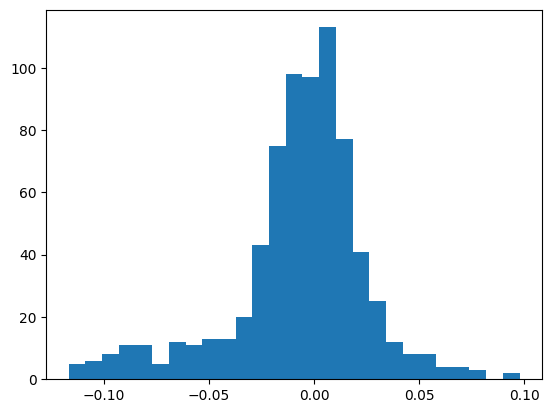

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


# fight_stats_df.outcome = fight_stats_df.outcome.map(lambda x: 1 if x == 'W' else 0)
corrs = []

for col in (set(train.columns) - set(['event', 'bout', 'outcome'])):
    corrs.append(train[col].corr(train.outcome))

corrs = np.array(corrs)
print (np.nanmean(corrs))
print (np.nanmedian(corrs))
print (np.nanmax(corrs))
print (np.nanmin(corrs))
plt.hist(corrs, bins=int(len(corrs)**0.5))

In [ ]:
def profit(df, clf, X_test, y_test):
    cash = 1000
    y_pred = clf.predict(X_test)
    df['result'] = y_test
    df['pred'] = y_pred
    for r in df.itertuples():
        if r.pred == 1:
            unit = cash * .01
            if r.result == 1:
                cash += unit * (100 / (r.precomp_odds * 100) - 1)
            else:
                cash -= unit
    return cash

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score

class OptunaTuning:
    def __init__(self, X_test, y_test, X_train, y_train):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train

    def objective(self, trial):
        search_space = {
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'tree_method': trial.suggest_categorical('tree_method', ['hist']),
            "objective": trial.suggest_categorical("objective", ["binary:logistic"]),
            "verbosity": trial.suggest_categorical("verbosity", [0]),
            "n_jobs": trial.suggest_categorical("n_jobs", [-1]),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 0, 20),
            "max_depth": trial.suggest_int("max_depth", 1, 20),
            "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
            "subsample": trial.suggest_float("subsample", 0.1, 1.0, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, log=True),
            "gamma": trial.suggest_float("gamma", .01, 0.4, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "eta": trial.suggest_float("eta", 0.1, 0.2, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        }
        model = xgb.XGBClassifier(**search_space)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        return accuracy

    def print_status(self, study, trial):
        print(f"Best value: {study.best_value}")
        print(f"Best params: {study.best_trial.params}")

    def run(self):
        study = optuna.create_study(direction="maximize")
        study.optimize(self.objective, n_trials=2000, callbacks=[self.print_status])
        print("Number of finished trials: ", len(study.trials))
        print("Best trial: ", study.best_trial.params)
        print("Best value: ", study.best_value)

In [ ]:
train.to_csv('training_data.csv')

In [ ]:
# clf = xgb.XGBClassifier(verbosity=0,
#                                 reg_lambda=0.023385762997113632,
#                                 reg_alpha=0.003694895205081855,
#                                 tree_method="gpu_hist",
#                                 objective="binary:logistic",
#                                 n_jobs=-1,
#                                 learning_rate=0.0059107879099318415,
#                                 min_child_weight=15,
#                                 max_depth=1,
#                                 max_delta_step=10,
#                                 subsample=0.5370056644955932,
#                                 colsample_bytree=0.5742787613391558,
#                                 gamma=0.09815563994539223,
#                                 n_estimators=143,
#                                 eta=0.1134711359195081,
#                                 seed=0)
m = OptunaTuning(test[list(set(train_stat_cols) - set(to_drop))], test['outcome'], train[list(set(train_stat_cols) - set(to_drop))], train['outcome'])
m.run()

[I 2023-09-28 16:20:46,044] A new study created in memory with name: no-name-42ed6785-daf1-4543-be04-ab896b0513cf
[I 2023-09-28 16:21:14,460] Trial 0 finished with value: 0.5276558384547849 and parameters: {'lambda': 1.4900242727189421, 'alpha': 0.015862714913756334, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.005935332340149065, 'min_child_weight': 7, 'max_depth': 19, 'max_delta_step': 3, 'subsample': 0.16884512321393874, 'colsample_bytree': 0.23320564082331635, 'gamma': 0.040145774769442547, 'n_estimators': 279, 'eta': 0.12574180278460642}. Best is trial 0 with value: 0.5276558384547849.


Best value: 0.5276558384547849
Best params: {'lambda': 1.4900242727189421, 'alpha': 0.015862714913756334, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.005935332340149065, 'min_child_weight': 7, 'max_depth': 19, 'max_delta_step': 3, 'subsample': 0.16884512321393874, 'colsample_bytree': 0.23320564082331635, 'gamma': 0.040145774769442547, 'n_estimators': 279, 'eta': 0.12574180278460642}


[I 2023-09-28 16:21:27,019] Trial 1 finished with value: 0.5127304653204565 and parameters: {'lambda': 2.3885444948252554, 'alpha': 0.06114177041072544, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.04522538041406445, 'min_child_weight': 15, 'max_depth': 18, 'max_delta_step': 10, 'subsample': 0.11961884857217808, 'colsample_bytree': 0.44995454831041637, 'gamma': 0.25970231723733667, 'n_estimators': 260, 'eta': 0.12435644583087384}. Best is trial 0 with value: 0.5276558384547849.


Best value: 0.5276558384547849
Best params: {'lambda': 1.4900242727189421, 'alpha': 0.015862714913756334, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.005935332340149065, 'min_child_weight': 7, 'max_depth': 19, 'max_delta_step': 3, 'subsample': 0.16884512321393874, 'colsample_bytree': 0.23320564082331635, 'gamma': 0.040145774769442547, 'n_estimators': 279, 'eta': 0.12574180278460642}


[I 2023-09-28 16:21:50,429] Trial 2 finished with value: 0.5171202809482002 and parameters: {'lambda': 1.2987567161054092, 'alpha': 0.004692056672765762, 'tree_method': 'hist', 'objective': 'reg:pseudohubererror', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.010357913399908818, 'min_child_weight': 12, 'max_depth': 13, 'max_delta_step': 3, 'subsample': 0.4489434358630896, 'colsample_bytree': 0.24784324795311943, 'gamma': 0.16641214820925002, 'n_estimators': 190, 'eta': 0.10220339407840391}. Best is trial 0 with value: 0.5276558384547849.


Best value: 0.5276558384547849
Best params: {'lambda': 1.4900242727189421, 'alpha': 0.015862714913756334, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.005935332340149065, 'min_child_weight': 7, 'max_depth': 19, 'max_delta_step': 3, 'subsample': 0.16884512321393874, 'colsample_bytree': 0.23320564082331635, 'gamma': 0.040145774769442547, 'n_estimators': 279, 'eta': 0.12574180278460642}


[I 2023-09-28 16:22:04,325] Trial 3 finished with value: 0.5171202809482002 and parameters: {'lambda': 8.838532554134838, 'alpha': 0.001529531499030992, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.041558811705195806, 'min_child_weight': 5, 'max_depth': 19, 'max_delta_step': 0, 'subsample': 0.49074650129281144, 'colsample_bytree': 0.6443390072216086, 'gamma': 0.028288735715593073, 'n_estimators': 111, 'eta': 0.1248639573461833}. Best is trial 0 with value: 0.5276558384547849.


Best value: 0.5276558384547849
Best params: {'lambda': 1.4900242727189421, 'alpha': 0.015862714913756334, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.005935332340149065, 'min_child_weight': 7, 'max_depth': 19, 'max_delta_step': 3, 'subsample': 0.16884512321393874, 'colsample_bytree': 0.23320564082331635, 'gamma': 0.040145774769442547, 'n_estimators': 279, 'eta': 0.12574180278460642}


[I 2023-09-28 16:22:40,695] Trial 4 finished with value: 0.533801580333626 and parameters: {'lambda': 0.017078973998315674, 'alpha': 0.007660019623804791, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.013344574127046385, 'min_child_weight': 7, 'max_depth': 15, 'max_delta_step': 8, 'subsample': 0.8911898750515833, 'colsample_bytree': 0.46236495566569313, 'gamma': 0.06985818567486686, 'n_estimators': 293, 'eta': 0.179501201658803}. Best is trial 4 with value: 0.533801580333626.


Best value: 0.533801580333626
Best params: {'lambda': 0.017078973998315674, 'alpha': 0.007660019623804791, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.013344574127046385, 'min_child_weight': 7, 'max_depth': 15, 'max_delta_step': 8, 'subsample': 0.8911898750515833, 'colsample_bytree': 0.46236495566569313, 'gamma': 0.06985818567486686, 'n_estimators': 293, 'eta': 0.179501201658803}


[I 2023-09-28 16:22:56,219] Trial 5 finished with value: 0.5188762071992976 and parameters: {'lambda': 0.009233296669128805, 'alpha': 0.003964501433449775, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.04498111801903284, 'min_child_weight': 9, 'max_depth': 19, 'max_delta_step': 5, 'subsample': 0.8437764854018938, 'colsample_bytree': 0.31999669421636345, 'gamma': 0.02462788715631038, 'n_estimators': 157, 'eta': 0.11441213438724068}. Best is trial 4 with value: 0.533801580333626.


Best value: 0.533801580333626
Best params: {'lambda': 0.017078973998315674, 'alpha': 0.007660019623804791, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.013344574127046385, 'min_child_weight': 7, 'max_depth': 15, 'max_delta_step': 8, 'subsample': 0.8911898750515833, 'colsample_bytree': 0.46236495566569313, 'gamma': 0.06985818567486686, 'n_estimators': 293, 'eta': 0.179501201658803}


[I 2023-09-28 16:23:48,916] Trial 6 finished with value: 0.5188762071992976 and parameters: {'lambda': 1.0315531356532326, 'alpha': 0.00531684510509296, 'tree_method': 'hist', 'objective': 'reg:pseudohubererror', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.010745183249795563, 'min_child_weight': 2, 'max_depth': 9, 'max_delta_step': 0, 'subsample': 0.35626405791338794, 'colsample_bytree': 0.8934909957910334, 'gamma': 0.045259724226728235, 'n_estimators': 321, 'eta': 0.12732735404374607}. Best is trial 4 with value: 0.533801580333626.


Best value: 0.533801580333626
Best params: {'lambda': 0.017078973998315674, 'alpha': 0.007660019623804791, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.013344574127046385, 'min_child_weight': 7, 'max_depth': 15, 'max_delta_step': 8, 'subsample': 0.8911898750515833, 'colsample_bytree': 0.46236495566569313, 'gamma': 0.06985818567486686, 'n_estimators': 293, 'eta': 0.179501201658803}


[I 2023-09-28 16:24:59,058] Trial 7 finished with value: 0.5083406496927129 and parameters: {'lambda': 9.234587941067987, 'alpha': 0.030686871307365034, 'tree_method': 'hist', 'objective': 'reg:pseudohubererror', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.06881583039498318, 'min_child_weight': 2, 'max_depth': 14, 'max_delta_step': 1, 'subsample': 0.9782589409049093, 'colsample_bytree': 0.7013649902495757, 'gamma': 0.03753875338300315, 'n_estimators': 134, 'eta': 0.12069448458155527}. Best is trial 4 with value: 0.533801580333626.


Best value: 0.533801580333626
Best params: {'lambda': 0.017078973998315674, 'alpha': 0.007660019623804791, 'tree_method': 'hist', 'objective': 'binary:logistic', 'verbosity': 0, 'n_jobs': -1, 'learning_rate': 0.013344574127046385, 'min_child_weight': 7, 'max_depth': 15, 'max_delta_step': 8, 'subsample': 0.8911898750515833, 'colsample_bytree': 0.46236495566569313, 'gamma': 0.06985818567486686, 'n_estimators': 293, 'eta': 0.179501201658803}


In [ ]:
# import statsmodels.formula.api as smf

# df = pd.read_csv('scrape_ufc_stats/ufc_fight_stats.csv')
# df.dropna()

# def clean_ts (x):
#     if type(x) == float:
#         return x
#     return int(x.split(' of ')[1])

# df.ROUND = df.ROUND.map(lambda x: int(x.split(' ')[1]) if type(x) != float else x)
# df['total_str_att'] = df['TOTAL STR.'].map(clean_ts)
# def get_fighters (df: pd.DataFrame) -> np.ndarray:
#     return df['FIGHTER'].unique()

# def get_bout_fighter_output_trend (df: pd.DataFrame) -> pd.DataFrame:
#     result = smf.ols('total_str_att ~ ROUND', data=df).fit()
#     return pd.DataFrame({
#         'fighter': [df.name[2]],
#         'trend': [result.params['ROUND']]
#     })

# def get_stamina (df: pd.DataFrame) -> pd.DataFrame:
#     bouts_fighters = df.groupby(['EVENT', 'BOUT', 'FIGHTER'])[['FIGHTER', 'ROUND', 'total_str_att']].apply(get_bout_fighter_output_trend)
#     return bouts_fighters

# stamina = get_stamina(df)


In [ ]:
stamina.reset_index(drop=True, inplace=True)

NameError: name 'stamina' is not defined

In [ ]:
fighter_staminas = stamina.groupby('fighter') \
                        .apply(lambda x: pd.DataFrame({'name': [x.name], 'trend': [x.trend.mean()]})) \
                        .reset_index(drop=True)

(array([  1.,   0.,   1.,   1.,   1.,   0.,   1.,   2.,   0.,   0.,   1.,
          1.,   1.,   1.,   1.,   1.,   2.,   4.,   4.,   5.,   8.,   7.,
          2.,  16.,  20.,  40.,  50.,  67.,  89., 162., 213., 313., 416.,
        356., 260., 135.,  90.,  64.,  32.,  14.,   9.,  10.,   5.,   1.,
          0.,   1.,   1.,   1.,   2.]),
 array([-97.        , -93.93877551, -90.87755102, -87.81632653,
        -84.75510204, -81.69387755, -78.63265306, -75.57142857,
        -72.51020408, -69.44897959, -66.3877551 , -63.32653061,
        -60.26530612, -57.20408163, -54.14285714, -51.08163265,
        -48.02040816, -44.95918367, -41.89795918, -38.83673469,
        -35.7755102 , -32.71428571, -29.65306122, -26.59183673,
        -23.53061224, -20.46938776, -17.40816327, -14.34693878,
        -11.28571429,  -8.2244898 ,  -5.16326531,  -2.10204082,
          0.95918367,   4.02040816,   7.08163265,  10.14285714,
         13.20408163,  16.26530612,  19.32653061,  22.3877551 ,
         25.44897959,  2

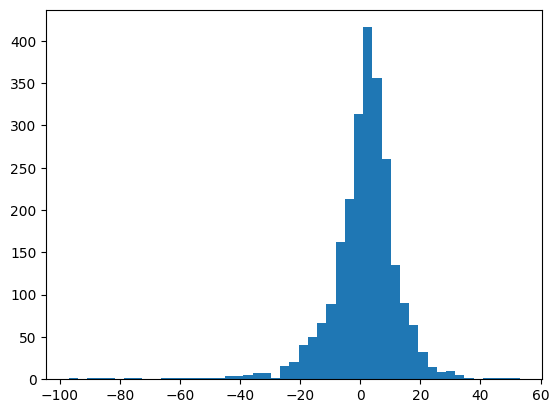

In [ ]:
# fighter_staminas.loc[fighter_staminas['name'] == 'Sean O\'Malley']
import matplotlib.pyplot as plt

plt.hist(fighter_staminas.trend, bins=int(len(fighter_staminas.index)**0.5))

In [ ]:
import numpy as np

H = np.mat([[0.7071, 0.7071, 0, 0], [0.7071, -0.7071, 0, 0], [0, 0, 0.7071, 0.7071], [0, 0, 0.7071, -0.7071]])
H_2 = np.mat([[0.7071, 0, 0.7071, 0], [0, 0.7071, 0, 0.7071], [0.7071, 0, -0.7071, 0], [0, 0.7071, 0, -0.7071]])

cnot_1 = np.mat([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
cnot_2 = np.mat([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])
circuit = cnot_1 * cnot_2 * cnot_1
q1 = np.mat([[0], [1], [0], [0]])
q2 = np.mat([[0], [0], [1], [0]])

print(H * cnot_2 * H)
print(circuit * q2)

[[ 0.49999041  0.49999041  0.49999041 -0.49999041]
 [ 0.49999041  0.49999041 -0.49999041  0.49999041]
 [ 0.49999041 -0.49999041  0.49999041  0.49999041]
 [-0.49999041  0.49999041  0.49999041  0.49999041]]
[[ 0.49999041  0.49999041  0.49999041 -0.49999041]
 [ 0.49999041  0.49999041 -0.49999041  0.49999041]
 [ 0.49999041 -0.49999041  0.49999041  0.49999041]
 [-0.49999041  0.49999041  0.49999041  0.49999041]]
